In [32]:
import pandas as pd
import numpy as np
import yfinance as yf
from yahoofinancials import YahooFinancials

import requests
from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)

import os

os.chdir('C:\\Users\\Krumini\\Python Notebook Projects\\Portfolio Construction\\')

pd.options.display.float_format = '{:,.4f}'.format
%precision %.4f

'%.4f'

# Picking assets

In [33]:
core = ['VT','VTI','VIG','VEA','VWO','BND','UCI','GLD']

swedish_stocks = ['SWED-A.ST','VOLV-B.ST','LIFCO-B.ST','VIT-B.ST','IAR-B.ST','SINCH.ST','ELAN-B.ST',
                 'ALFA.ST','INDT.ST','HUSQ-B.ST','LAMM-B.ST','CLAS-B.ST','MCAP.ST','BRE2.ST',
                 'INWI.ST','BETS-B.ST','SHOT.ST','KNOW.ST','EVO.ST','SEB-A.ST','ASPIRE.ST',
                 'PDX.ST','CTM.ST','HM-B.ST','VITR.ST','BOL.ST','KAMBI.ST','HUM.ST','SCA-A.ST',
                 'ATCO-A.ST','WISE.ST','GLOBAL.ST']

baltic_stocks = ['NTU1L.VS','PZV1L.VS','NCN1T.TL','GRG1L.VS','TKM1T.TL','TEL1L.VS','APG1L.VS',
                 'GZE1R.RG','OLF1R.RG','MDARA.RG']

additional_stocks = ['PFE','MSFT','IBM','O','MMM','T','MCD','GNTX','KIE.L','SWJ.DE','TOT','LI.PA',
                    'HPT']

additional_ETFs = ['MDT','WMT','VAW','IYM','MXI','RXI','PEZ','VCR','VFH','IYG','IXG','VNQ','TAO','RWX',
                   'RWO','VDC','KXI','RHS','VHT','IYH','IXJ','IHI','PTH','HLT.PA','XBI','XLV','XLU','IDU',
                   'VPU','PUI','JXI','RYU','UPW','VOX','IYZ','TEL.PA','XLE','VDE','IYE','XEG.TO','IXC','PXE',
                   'XOP','XES','XSER.L','TAN','XLI','VIS','IYT','ITA','EXI','RGI','XSNR.L','XLK','IYW','VGT',
                   'IGV','QTEC','PSI']

benchmark = 'VT'

# Gathering data

In [34]:
asset_list = core + swedish_stocks + baltic_stocks + additional_stocks + additional_ETFs


prices = yf.download(asset_list, start='2000-01-01')['Close']
prices.to_csv('C:\\Users\\Krumini\\Python Notebook Projects\\Portfolio Construction\\Prices.csv', encoding='utf-8')

[*********************100%***********************]  122 of 122 downloaded


In [35]:
def clean_returns(ret):
    if type(ret) == pd.core.series.Series:
        temp = ret[np.logical_or(ret > ret.std() * 12, ret < -ret.std() * 12)].dropna()
        ret[temp.index] = 0.0
    else:
        for a in ret.columns:
            temp = ret[np.logical_or(ret > ret.std() * 12, ret < -ret.std() * 12)][a].dropna()
            ret[a][temp.index] = 0.0
    return ret

In [36]:
dret = prices.asfreq(freq='D', method='pad').pct_change().dropna()
dret = clean_returns(dret)
dret.to_csv('d_Returns.csv', encoding='utf-8')

wret = prices.asfreq(freq="W", method='pad').pct_change().dropna()
wret = clean_returns(wret)
wret.to_csv('w_Returns.csv', encoding='utf-8')

mret = prices.asfreq(freq="M", method='pad').pct_change().dropna()
mret = clean_returns(mret)
mret.to_csv('m_Returns.csv', encoding='utf-8')

clean_returns(wret).min().sort_values().head(), clean_returns(wret).max().sort_values(ascending=False).head()

(GLOBAL.ST   -0.5463
 KIE.L       -0.4400
 SWED-A.ST   -0.2545
 KAMBI.ST    -0.2244
 CTM.ST      -0.1931
 dtype: float64, GLOBAL.ST   0.4784
 BETS-B.ST   0.3203
 PZV1L.VS    0.2907
 KIE.L       0.2789
 ASPIRE.ST   0.2781
 dtype: float64)

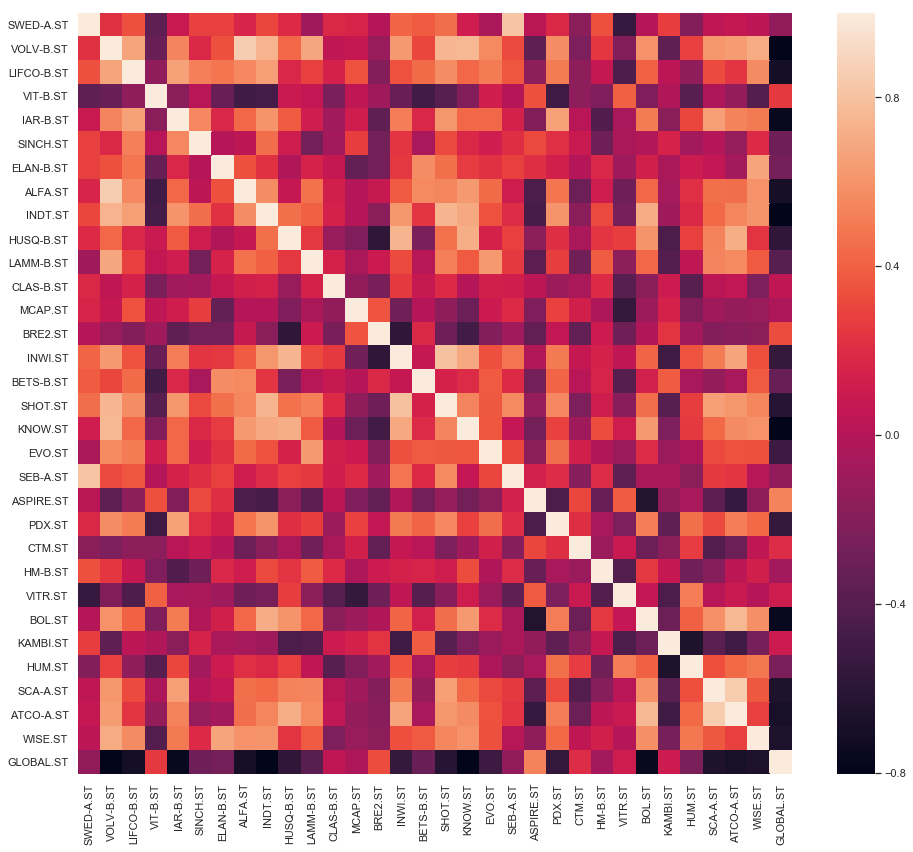

In [51]:
sns.heatmap(mret[swedish_stocks].corr(method='spearman'), ax=plt.subplots(figsize=(16,14))[1])
plt.show()

## Getting descriptive data

In [48]:
def etf_info(asset):
    # Used for ETFs

    aPath = 'https://finance.yahoo.com/quote/' + asset

    soup = BeautifulSoup(requests.get(aPath).text, "html.parser")

    expense = soup.find('td', {'data-test':'EXPENSE_RATIO-value'}).text
    expense = float(expense.split('%')[0])/100

    ayield = soup.find('td', {'data-test':'TD_YIELD-value'}).text.split('%')[0]
    ayield = float(ayield)/100

    aPath = 'https://finance.yahoo.com/quote/' + asset + '/holdings?p=' + asset
    soup = BeautifulSoup(requests.get(aPath).text, "html.parser")

    # Getting Equity Holdigns            
    pe = float(soup.find('span', {'data-reactid':"131"}).text)
    pb = float(soup.find('span', {'data-reactid':"136"}).text)
    ps = float(soup.find('span', {'data-reactid':"141"}).text)
    pcf = float(soup.find('span', {'data-reactid':"146"}).text)

    equityHoldings = pd.DataFrame([pe, pb, ps, pcf],
                                  index = ['Price/Earnings','Price/Book','Price/Sales','Price/Cashflow'],
                                  columns = list([asset])
                                 )

    # Getting Bond Ratings
    us_gov = float(soup.find('span', {'data-reactid':"170"}).text.split('%')[0])/100
    aaa = float(soup.find('span', {'data-reactid':"175"}).text.split('%')[0])/100
    aa = float(soup.find('span', {'data-reactid':"180"}).text.split('%')[0])/100
    a = float(soup.find('span', {'data-reactid':"185"}).text.split('%')[0])/100
    bbb = float(soup.find('span', {'data-reactid':"190"}).text.split('%')[0])/100
    bb = float(soup.find('span', {'data-reactid':"195"}).text.split('%')[0])/100
    b = float(soup.find('span', {'data-reactid':"200"}).text.split('%')[0])/100
    belowB = float(soup.find('span', {'data-reactid':"205"}).text.split('%')[0])/100
    other = float(soup.find('span', {'data-reactid':"210"}).text.split('%')[0])/100

    bondRatings = pd.DataFrame([us_gov, aaa, aa, a, bbb, bb, b, belowB, other],
                               index = ['US Goverment','AAA','AA','A','BBB','BB','B','Below B','Others'],
                               columns = list([asset])
                              )

    # Sector Weightings
    if len(soup.find_all('span', {'data-reactid':"36"})) > 1:
        basicMaterials = float(soup.find_all('span', {'data-reactid':"36"})[1].text.split('%')[0])/100
    else:
        basicMaterials = float(soup.find('span', {'data-reactid':"36"}).text.split('%')[0])/100

    if len(soup.find_all('span', {'data-reactid':"44"})) > 1:
        consumerCyclical = float(soup.find_all('span', {'data-reactid':"44"})[1].text.split('%')[0])/100
    else:
        consumerCyclical = float(soup.find('span', {'data-reactid':"44"}).text.split('%')[0])/100

    if len(soup.find_all('span', {'data-reactid':"52"})) > 1:
        financialServices = float(soup.find_all('span', {'data-reactid':"52"})[1].text.split('%')[0])/100
    else:
        financialServices = float(soup.find('span', {'data-reactid':"52"}).text.split('%')[0])/100

    if len(soup.find_all('span', {'data-reactid':"60"})) > 1:
        realestate = float(soup.find_all('span', {'data-reactid':"60"})[1].text.split('%')[0])/100
    else:
        realestate = float(soup.find('span', {'data-reactid':"60"}).text.split('%')[0])/100

    if len(soup.find_all('span', {'data-reactid':"68"})) > 1:
        consumerDefensive = float(soup.find_all('span', {'data-reactid':"68"})[1].text.split('%')[0])/100
    else:
        consumerDefensive = float(soup.find('span', {'data-reactid':"68"}).text.split('%')[0])/100

    if len(soup.find_all('span', {'data-reactid':"76"})) > 1:
        healthcare = float(soup.find_all('span', {'data-reactid':"76"})[1].text.split('%')[0])/100
    else:
        healthcare = float(soup.find('span', {'data-reactid':"76"}).text.split('%')[0])/100

    if len(soup.find_all('span', {'data-reactid':"84"})) > 1:
        utilities = float(soup.find_all('span', {'data-reactid':"84"})[1].text.split('%')[0])/100
    else:
        utilities = float(soup.find('span', {'data-reactid':"84"}).text.split('%')[0])/100

    if len(soup.find_all('span', {'data-reactid':"92"})) > 1:
        communicationServices = float(soup.find_all('span', {'data-reactid':"92"})[1].text.split('%')[0])/100
    else:
        communicationServices = float(soup.find('span', {'data-reactid':"92"}).text.split('%')[0])/100

    if len(soup.find_all('span', {'data-reactid':"100"})) > 1:
        energy = float(soup.find_all('span', {'data-reactid':"100"})[1].text.split('%')[0])/100
    else:
        energy = float(soup.find('span', {'data-reactid':"100"}).text.split('%')[0])/100

    if len(soup.find_all('span', {'data-reactid':"108"})) > 1:
        industrials = float(soup.find_all('span', {'data-reactid':"108"})[1].text.split('%')[0])/100
    else:
        industrials = float(soup.find('span', {'data-reactid':"108"}).text.split('%')[0])/100

    if len(soup.find_all('span', {'data-reactid':"116"})) > 1:
        technology = float(soup.find_all('span', {'data-reactid':"116"})[1].text.split('%')[0])/100
    else:
        technology = float(soup.find('span', {'data-reactid':"116"}).text.split('%')[0])/100

    sectors = pd.DataFrame([basicMaterials, consumerCyclical, financialServices, realestate, 
                            consumerDefensive, healthcare, utilities, communicationServices,
                            energy, industrials, technology], 
                            index = ['Basic Materials','CONSUMER_CYCLICAL','Financial Services',
                                     'Realestate','Consumer Defensive','Healthcare','Utilities',
                                    'Communication Services','Energy','Industrials','Technology'
                                    ],
                           columns = list([asset])
                          )

    return [equityHoldings, sectors, bondRatings, ayield, expense]

etf_info('VIG')[1]

,VIG
Basic Materials,0.0463
CONSUMER_CYCLICAL,0.1049
Financial Services,0.1192
Realestate,0.0000
Consumer Defensive,0.1627
Healthcare,0.1284
Utilities,0.0600
Communication Services,0.0368
Energy,0.0000
Industrials,0.2307


In [39]:
def mult_by_letter(text):
    if text[-1] == 'B':
        text = float(text[:-1]) * 1000000000
    elif text[-1] == 'M':
        text = float(text[:-1]) * 1000000
    elif text[-1] == 'k':
        text = float(text[:-1]) * 1000
    elif text[-1] == 'T':
        text = float(text[:-1]) * 1000000000000
    
    return text

In [46]:
def stock_info(asset):
    # Used for single stocks

    aPath = 'https://finance.yahoo.com/quote/' + asset + '/profile?p=' + asset
    soup = BeautifulSoup(requests.get(aPath).text, "html.parser")

    sectors = pd.DataFrame([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0], 
                           index = ['Basic Materials','CONSUMER_CYCLICAL','Financial Services',
                                    'Realestate','Consumer Defensive','Healthcare','Utilities',
                                    'Communication Services','Energy','Industrials','Technology'
                                   ],
                           columns = list([asset])
                          )

    react21 = soup.find_all('span', {'data-reactid':"21"})
    
    if len(react21) > 1:        
        sec = react21[-1].text
        
        if sec == 'Consumer Cyclical': sec = 'CONSUMER_CYCLICAL'
        if sec == 'Real Estate': sec = 'Realestate'
        
        if not sec in sectors.index:
            sec = soup.find('span', {'data-reactid':"23"}).text
            if sec == 'Consumer Cyclical': sec = 'CONSUMER_CYCLICAL'
            if sec == 'Real Estate': sec = 'Realestate'
                
            if not sec in sectors.index: print('Sector {} not found for {}'.format(sec, asset))
    else:
        sec = soup.find('span', {'data-reactid':"23"}).text
        if sec == 'Consumer Cyclical': sec = 'CONSUMER_CYCLICAL'
        if sec == 'Real Estate': sec = 'Realestate'
    #print(soup.find_all('span'))

    sectors.loc[sec, asset] = 1

    data = YahooFinancials(asset).get_summary_data()[asset]
    summary_data = pd.DataFrame(data, index = data.keys()).iloc[0].T
    price = YahooFinancials(asset).get_current_price()    
    
    try:
        revenue = float(yf.Ticker('T').financials.loc['Total Revenue'].iloc[0])
    except:
        revenue = 0.0
    
    sharesOut = yf.Ticker(asset).info['sharesOutstanding']
    netIncome = YahooFinancials(asset).get_net_income()
        
    if sharesOut != None and netIncome != None:
        pe = sharesOut * price / netIncome
    elif summary_data.trailingPE != None:        
        pe = summary_data.trailingPE
    else:
        pe = 0.0

    book = YahooFinancials(asset).get_key_statistics_data()[asset]['bookValue']
    if book != None:
        pb = price / book
    else:
        pb = 0.0
    
    if revenue != 0.0 and sharesOut != None:
        ps = price / (revenue / sharesOut)
    
    #if the number we get here is why over the top, we use staticly calculated P/S
        if summary_data.priceToSalesTrailing12Months != None:
            if abs(ps) > abs(3 * summary_data.priceToSalesTrailing12Months): 
                ps = summary_data.priceToSalesTrailing12Months
                
    elif summary_data.priceToSalesTrailing12Months != None:
        ps = summary_data.priceToSalesTrailing12Months
    else:
        ps = 0.0

    opi = YahooFinancials(asset).get_net_income_from_continuing_ops()
    if summary_data.marketCap != None and opi != None:
        pcf = summary_data.marketCap / opi
    else:
        pcf = 0.0

    try:
        payoutRatio = summary_data.payoutRatio
        try:
            dividendYield = summary_data.trailingAnnualDividendRate / price
        except:
            dividendYield = 0.0
    except:
        payoutRatio = 0.0
        dividendYield = 0.0    

    equityHoldings = pd.DataFrame([pe, pb, ps, pcf],
                                  index = ['Price/Earnings','Price/Book','Price/Sales','Price/Cashflow'],
                                  columns = list([asset])
                                 )
    
    return [equityHoldings, sectors, payoutRatio, dividendYield]

# TEST
stock_info('EVO.ST')

[                 EVO.ST
 Price/Earnings 433.0575
 Price/Book      44.9819
 Price/Sales    211.6645
 Price/Cashflow 433.0575,                         EVO.ST
 Basic Materials         0.0000
 CONSUMER_CYCLICAL       1.0000
 Financial Services      0.0000
 Realestate              0.0000
 Consumer Defensive      0.0000
 Healthcare              0.0000
 Utilities               0.0000
 Communication Services  0.0000
 Energy                  0.0000
 Industrials             0.0000
 Technology              0.0000, 0.4013, 0.005266331658291458]

In [49]:
sectors = pd.DataFrame(index = ['Basic Materials','CONSUMER_CYCLICAL','Financial Services',
                                'Realestate','Consumer Defensive','Healthcare','Utilities',
                                'Communication Services','Energy','Industrials','Technology'])

equityRatios = pd.DataFrame(index = ['Price/Earnings','Price/Book','Price/Sales','Price/Cashflow'])
bondRatings = pd.DataFrame(index = ['US Goverment','AAA','AA','A','BBB','BB','B','Below B','Others'])

yields = pd.DataFrame(index=asset_list)
yields['Yields'] = 0.0
yields['Expenses'] = 0.0

asset_info = pd.DataFrame(index=asset_list)
asset_info['NAME'] = ''
asset_info['TYPE'] = ''
asset_info['GROUP'] = ''
asset_info['REGION'] = ''
asset_info['CCY'] = ''
asset_info['LAST PRICE'] = 0.0
asset_info['PAYOUT'] = 0.0
    
for a in asset_list:
    print('Reading data for {} ... ({}%)'.format(a, round(100 * (1+asset_list.index(a))/(1+len(asset_list)), 2)))
    data = yf.Ticker(a).info
    
    asset_type = data['quoteType']   

    if a in core:
        asset_info.loc[a, 'GROUP'] = 'CORE'
    elif a in swedish_stocks:
        asset_info.loc[a, 'GROUP'] = 'SWEDISH'
    elif a in baltic_stocks:
        asset_info.loc[a, 'GROUP'] = 'BALTIC'
    elif a in additional_stocks:
        asset_info.loc[a, 'GROUP'] = 'OTHER STOCKS'
    else:
        asset_info.loc[a, 'GROUP'] = 'OTHER ETFS'
    
    asset_info.loc[a, 'TYPE'] = data['quoteType']
    asset_info.loc[a, 'NAME'] = data['shortName']
    asset_info.loc[a, 'CCY'] = data['currency']
    asset_info.loc[a, 'REGION'] = str(data['market']).upper()
    asset_info.loc[a, 'LAST PRICE'] = YahooFinancials(a).get_current_price()
    
    if asset_type == 'ETF':
        etf_data = etf_info(a)
        
        equityRatios[a] = etf_data[0]
        sectors[a] = etf_data[1]
        bondRatings[a] = etf_data[2]
                
    elif asset_type == 'EQUITY':
        equity_data = stock_info(a)
        
        equityRatios[a] = equity_data[0]
        sectors[a] = equity_data[1]
        asset_info.loc[a, 'PAYOUT'] = equity_data[2]
        yields.loc[a, 'Yields'] = equity_data[3]
        bondRatings[a] = 0.0
        
    else:
        print('Failed to match type for {} type {}'.format(a, asset_type))
            
equityRatios.to_csv('equityRatios.csv', encoding='utf-8')
sectors.to_csv('sectors.csv', encoding='utf-8')
bondRatings.to_csv('bondRatings.csv', encoding='utf-8')
asset_info.to_csv('AssetInformation.csv', encoding='utf-8')

asset_info

Reading data for VT ... (0.81%)
Reading data for VTI ... (1.63%)
Reading data for VIG ... (2.44%)
Reading data for VEA ... (3.25%)
Reading data for VWO ... (4.07%)
Reading data for BND ... (4.88%)
Reading data for UCI ... (5.69%)
Reading data for GLD ... (6.5%)
Reading data for SWED-A.ST ... (7.32%)
Reading data for VOLV-B.ST ... (8.13%)
Reading data for LIFCO-B.ST ... (8.94%)
Reading data for VIT-B.ST ... (9.76%)
Reading data for IAR-B.ST ... (10.57%)
Reading data for SINCH.ST ... (11.38%)
Reading data for ELAN-B.ST ... (12.2%)
Reading data for ALFA.ST ... (13.01%)
Reading data for INDT.ST ... (13.82%)
Reading data for HUSQ-B.ST ... (14.63%)
Reading data for LAMM-B.ST ... (15.45%)
Reading data for CLAS-B.ST ... (16.26%)
Reading data for MCAP.ST ... (17.07%)
Reading data for BRE2.ST ... (17.89%)
Reading data for INWI.ST ... (18.7%)
Reading data for BETS-B.ST ... (19.51%)
Reading data for SHOT.ST ... (20.33%)
Reading data for KNOW.ST ... (21.14%)
Reading data for EVO.ST ... (21.95%)
Rea

,NAME,TYPE,GROUP,REGION,CCY,LAST PRICE,PAYOUT
VT,Vanguard Total World Stock Inde,ETF,CORE,US_MARKET,USD,76.0300,0.0000
VTI,Vanguard Total Stock Market ETF,ETF,CORE,US_MARKET,USD,152.7100,0.0000
VIG,Vanguard Div Appreciation ETF,ETF,CORE,US_MARKET,USD,120.4100,0.0000
VEA,Vanguard FTSE Developed Markets,ETF,CORE,US_MARKET,USD,41.6900,0.0000
VWO,Vanguard FTSE Emerging Markets,ETF,CORE,US_MARKET,USD,41.4400,0.0000
BND,Vanguard Total Bond Market ETF,ETF,CORE,US_MARKET,USD,83.8900,0.0000
UCI,E-TRACS USB Bloomberg Commodity,ETF,CORE,US_MARKET,USD,14.2400,0.0000
GLD,SPDR Gold Trust,ETF,CORE,US_MARKET,USD,141.2800,0.0000
SWED-A.ST,Swedbank AB ser A,EQUITY,SWEDISH,SE_MARKET,SEK,139.9500,0.7684
VOLV-B.ST,"Volvo, AB ser. B",EQUITY,SWEDISH,SE_MARKET,SEK,143.4000,0.3201


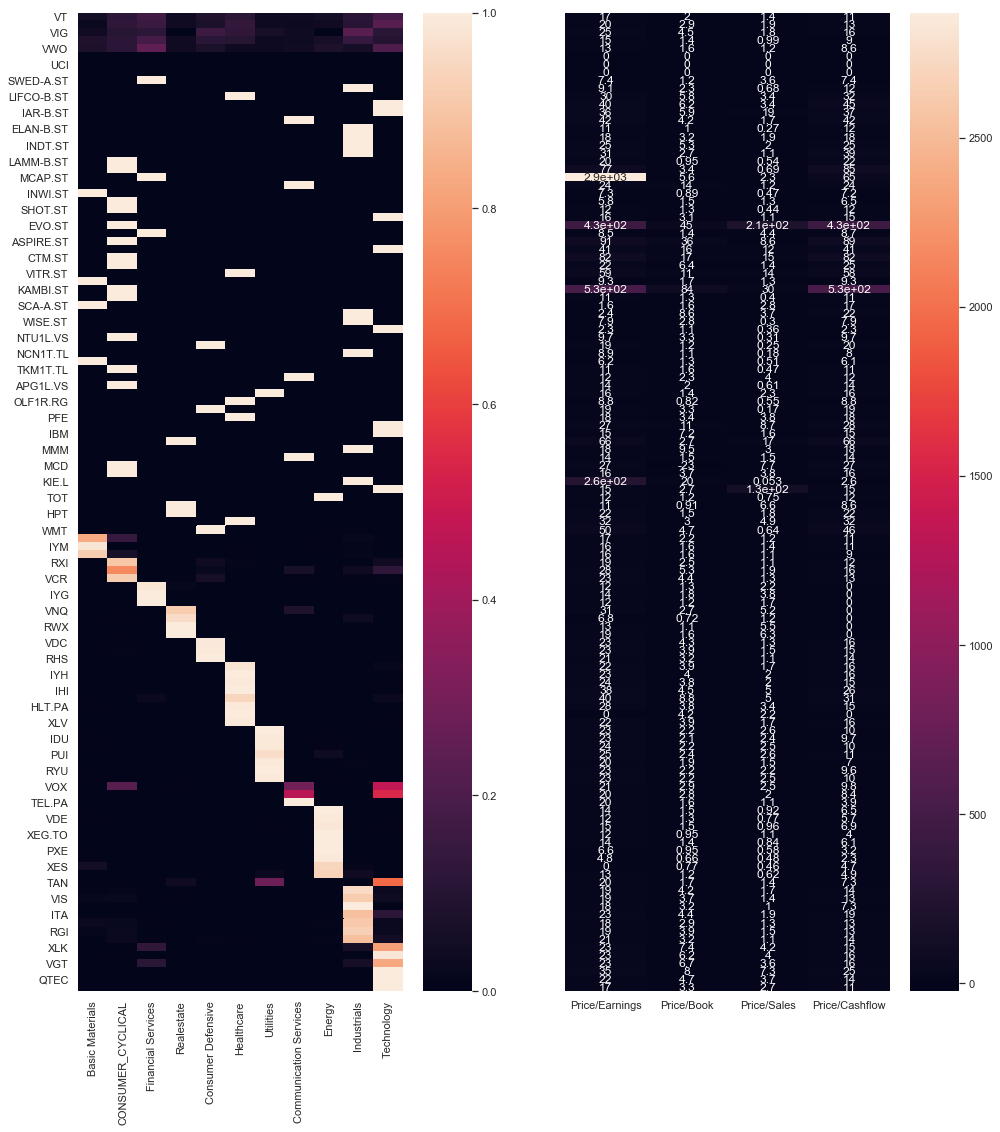

In [52]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16,18))

sns.heatmap(sectors.T, ax=axs[0])
sns.heatmap(equityRatios.T, annot=True, ax=axs[1])
plt.show()

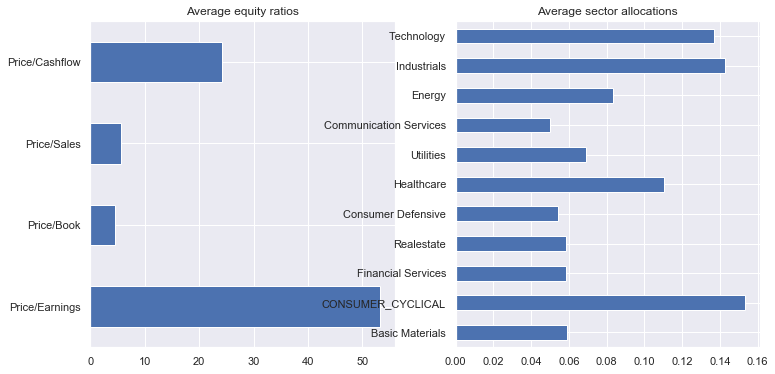

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))

equityRatios.T.mean().plot(kind='barh', title='Average equity ratios', ax=axs[0])
sectors.T.mean().plot(kind='barh', title='Average sector allocations', ax=axs[1])
plt.show()

In [54]:
ratios_x_sectors = pd.DataFrame(columns=sectors.index, index=equityRatios.index)

for r in equityRatios.index:
    for s in sectors.index:        
        values = equityRatios[sectors[sectors.columns[sectors.loc[s] > 0.5]].loc[s].index].loc[r]
        weights = sectors[values.index].loc[s] / np.sum(sectors[values.index].loc[s])
        
        ratios_x_sectors.loc[r, s] = np.dot(values, weights)
        
ratios_x_sectors

,Basic Materials,CONSUMER_CYCLICAL,Financial Services,Realestate,Consumer Defensive,Healthcare,Utilities,Communication Services,Energy,Industrials,Technology
Price/Earnings,10.2005,80.4961,489.0721,23.9041,25.9247,26.4977,22.1455,22.6389,10.3648,31.3804,23.6228
Price/Book,1.5441,11.0124,2.0845,1.5927,3.4457,4.7005,2.0834,4.6998,1.1422,4.8642,5.9743
Price/Sales,1.2789,16.2976,3.0138,6.2843,0.8134,3.8093,2.3175,1.8931,0.7465,1.3561,13.8552
Price/Cashflow,10.0355,79.8320,13.5649,14.0494,21.7987,21.8709,10.3832,19.2385,5.6533,15.1091,20.0533


In [55]:
asset_info['Price/Earnings'] = 0.0
asset_info['Price/Book'] = 0.0
asset_info['Price/Sales'] = 0.0
asset_info['Price/Cashflow'] = 0.0

for a in asset_info.index:
    for r in ratios_x_sectors.index:
        sector = sectors[a]
        sec_ratios = ratios_x_sectors.loc[r]
        equityRatio = equityRatios.loc[r, a]
        
        if equityRatio == 0.0 or np.dot(sector, sec_ratios) == 0.0:
            asset_info.loc[a, r] = 0.0
        else:
            asset_info.loc[a, r] = equityRatio / np.dot(sector, sec_ratios)
            
asset_info.head()

,NAME,TYPE,GROUP,REGION,CCY,LAST PRICE,PAYOUT,Price/Earnings,Price/Book,Price/Sales,Price/Cashflow
VT,Vanguard Total World Stock Inde,ETF,CORE,US_MARKET,USD,76.0300,0.0000,0.1522,0.4448,0.2265,0.4501
VTI,Vanguard Total Stock Market ETF,ETF,CORE,US_MARKET,USD,152.7100,0.0000,0.1913,0.6045,0.2799,0.5186
VIG,Vanguard Div Appreciation ETF,ETF,CORE,US_MARKET,USD,120.4100,0.0000,0.2832,0.9572,0.3786,0.6620
VEA,Vanguard FTSE Developed Markets,ETF,CORE,US_MARKET,USD,41.6900,0.0000,0.1282,0.3384,0.1996,0.3897
VWO,Vanguard FTSE Emerging Markets,ETF,CORE,US_MARKET,USD,41.4400,0.0000,0.0912,0.3843,0.1871,0.3749


In [59]:
etfs = asset_info[asset_info['TYPE'] == 'ETF'].index

rel_prices = wret[etfs].add(1).cumprod().mul(100).dropna()

features = sectors.append(equityRatios)
factors = pd.DataFrame(index = rel_prices.index)

for i in range(len(sectors.index)):
    weights = np.ones(len(etfs))
    cc = 0
    
    for c in etfs:    
        weights[cc] = sectors.loc[sectors.index[i], c]
        cc += 1
    
    factors[sectors.index[i]] = np.dot(wret[etfs], weights / np.sum(weights))
    
factors = factors.add(1).cumprod().mul(100)

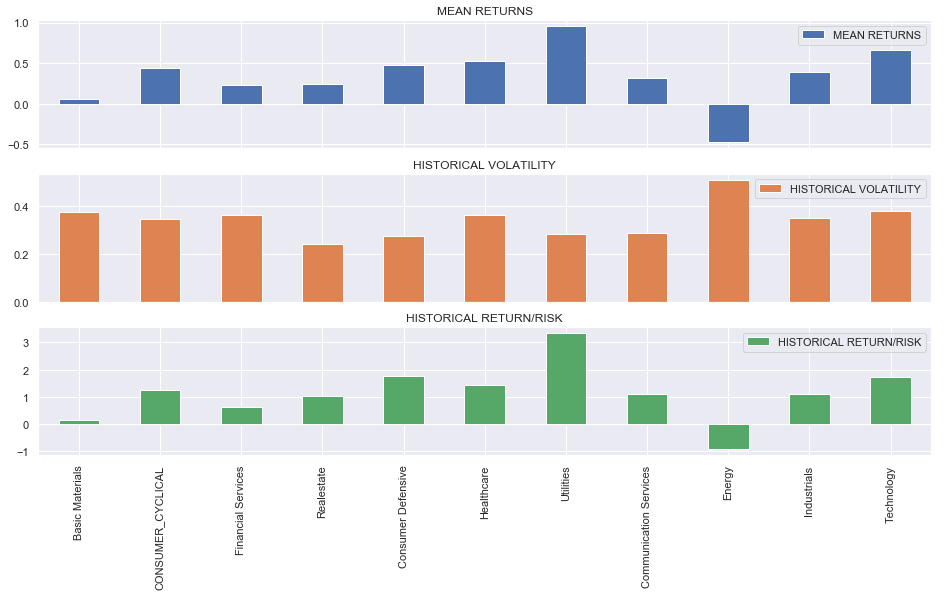

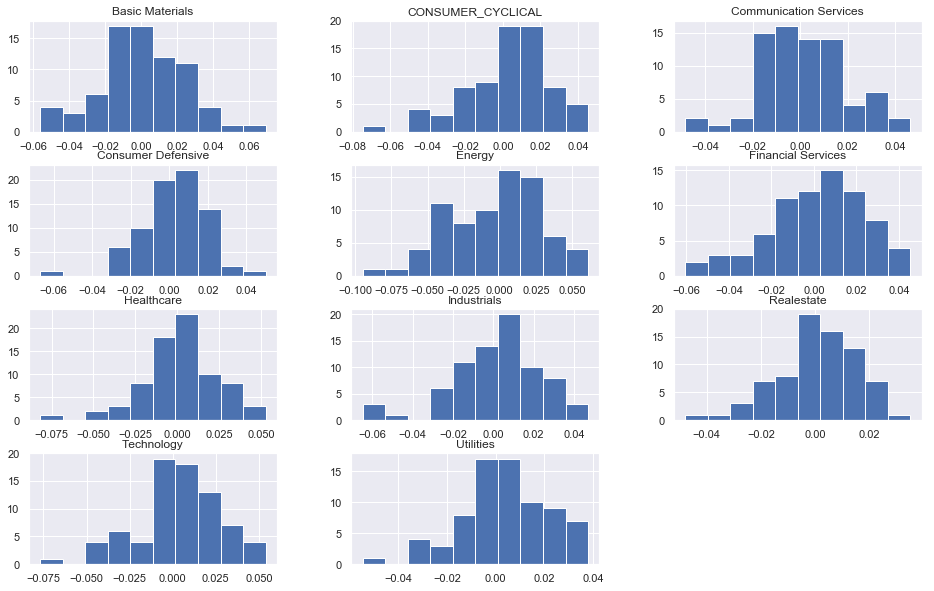

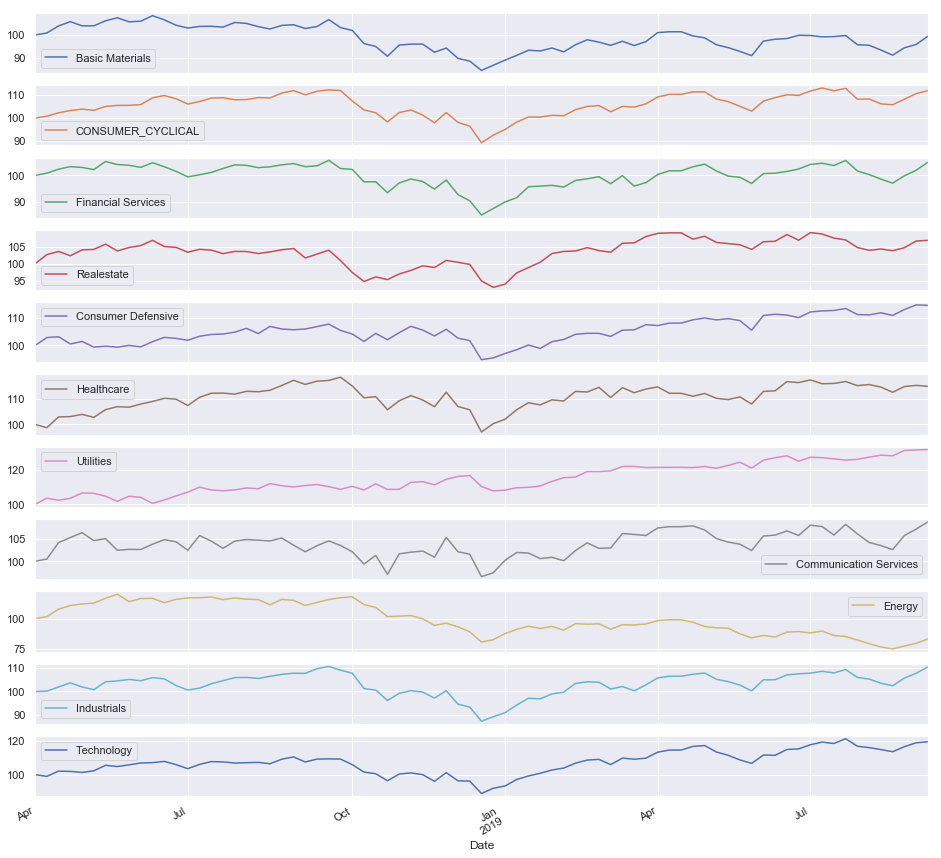

In [63]:
wFactorReturns = factors.asfreq(freq='W', method='pad').pct_change().dropna()
fact_summary = pd.DataFrame({'MEAN RETURNS':wFactorReturns.mean().mul(252),
                             'HISTORICAL VOLATILITY':wFactorReturns.std().mul(np.sqrt(252)),
                            }, index=factors.columns)

fact_summary['HISTORICAL RETURN/RISK'] = fact_summary['MEAN RETURNS'] / fact_summary['HISTORICAL VOLATILITY']

fact_summary.plot(kind='bar', subplots=True, figsize=(16,8))
plt.show()

wFactorReturns.hist(figsize=(16,10))
plt.show()

factors.plot(subplots=True, figsize=(16,16))
plt.show()

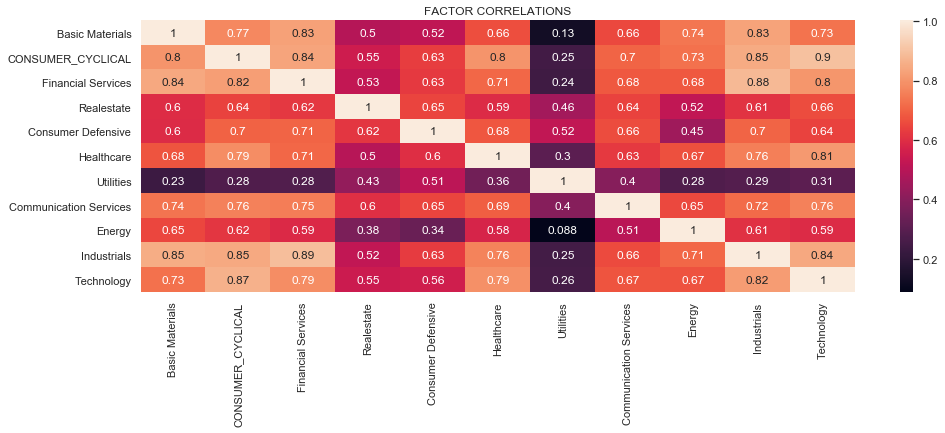

In [83]:
from scipy import stats

def correl(x, y):
    
    if len(x) != len(y):
        if len(x) < len(y):
            y = y[len(y)-len(x):]
        else:
            x = x[len(x)-len(y):]
    
    corrs = []
    corrs.append([stats.spearmanr(x, y)[0], stats.spearmanr(x, y)[1]])
    corrs.append([stats.pearsonr(x, y)[0], stats.pearsonr(x, y)[1]])
    corrs.append([stats.kendalltau(x, y)[0], stats.kendalltau(x, y)[1]])
    corrs.append([stats.pointbiserialr(x, y)[0], stats.pointbiserialr(x, y)[1]])
    corrs.append([x.cov(y)/np.var(x), 0.05])
    
    corr_values = []
    p_values = []
    for cor in corrs:        
        if cor[1] <= 0.05:            
            corr_values.append(cor[0])
            p_values.append(cor[1])

    #Take weighted average giving biggest weight to lowest p-value
    return np.dot(corr_values, (1-np.array(p_values))/np.sum(1-np.array(p_values)))

factor_correls = pd.DataFrame(columns = wFactorReturns.columns, index = wFactorReturns.columns, dtype=np.float32)
for x in wFactorReturns.columns:
    for y in wFactorReturns.columns:
        factor_correls.loc[x, y] = float(correl(wFactorReturns[x], wFactorReturns[y]))
        
sns.heatmap(factor_correls, annot = True, ax=plt.subplots(figsize=(16,5))[1])
plt.title('FACTOR CORRELATIONS')
plt.show()

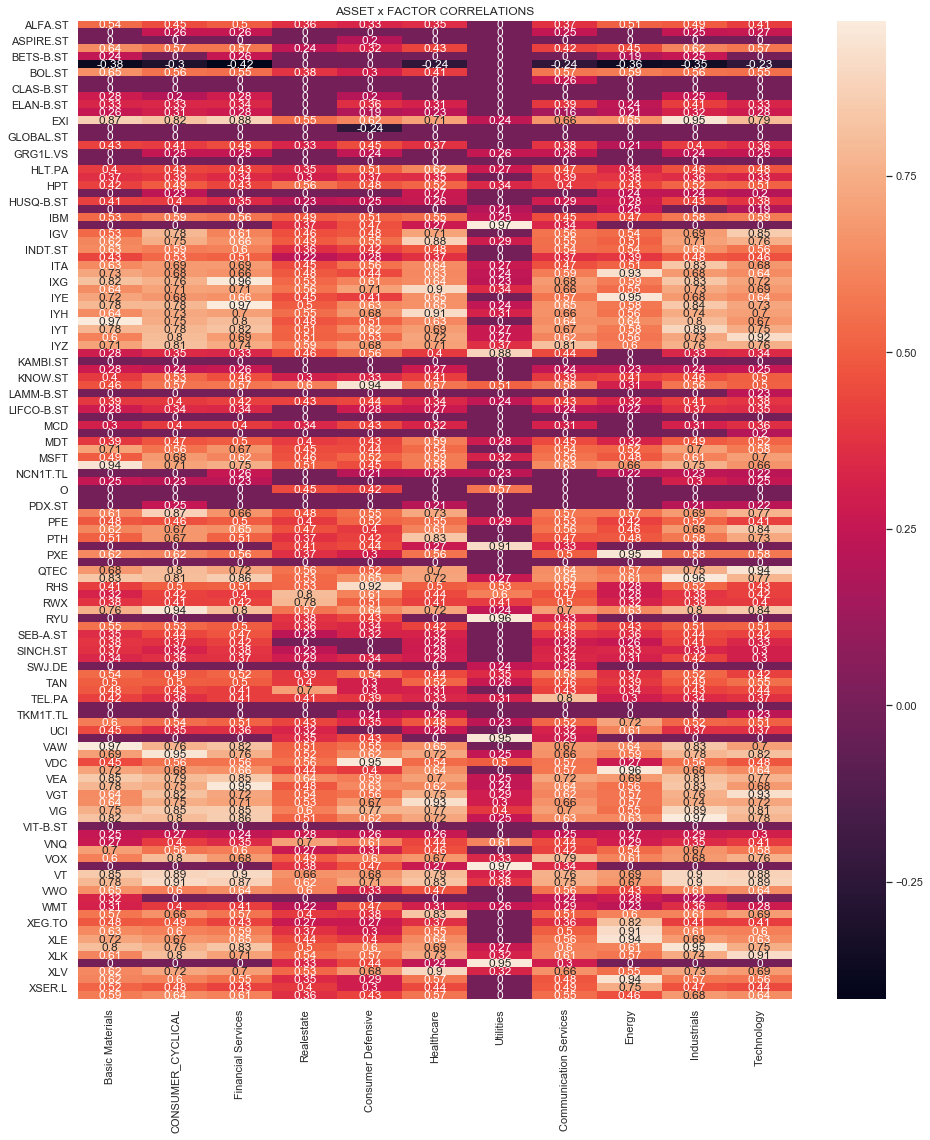

In [65]:
len1 = len(wFactorReturns.index)
len2 = len(wret.index)

if len1 < len2:
    assets_x_factors_correls = pd.DataFrame(columns = wFactorReturns.columns, index = wret.columns, dtype=np.float32)
    correction = len2 - len1
    
    for x in wret.columns:
        for y in wFactorReturns.columns:
            assets_x_factors_correls.loc[x, y] = float(correl(wret.iloc[correction:][x], wFactorReturns[y]))
            
elif len2 > len1:
    assets_x_factors_correls = pd.DataFrame(columns = wFactorReturns.columns, index = wret.columns, dtype=np.float32)
    correction = len2 - len1
    
    for x in wret.columns:
        for y in wFactorReturns.columns:
            assets_x_factors_correls.loc[x, y] = float(correl(wret[x], wFactorReturns.iloc[correction:][y]))
else:
    assets_x_factors_correls = pd.DataFrame(columns = wFactorReturns.columns, index = wret.columns, dtype=np.float32)
    
    for x in wret.columns:
        for y in wFactorReturns.columns:
            assets_x_factors_correls.loc[x, y] = float(correl(wret[x], wFactorReturns[y]))
        
sns.heatmap(assets_x_factors_correls, annot = True, ax=plt.subplots(figsize=(16,18))[1])
plt.title('ASSET x FACTOR CORRELATIONS')
plt.show()

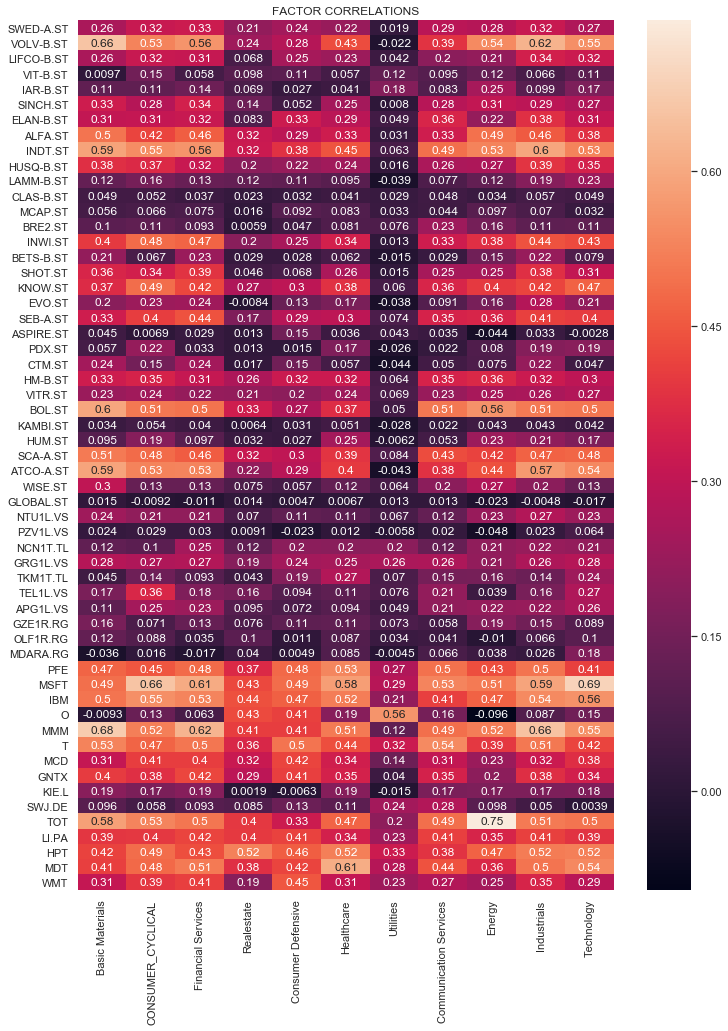

In [90]:
stocks = asset_info[asset_info['TYPE'] != 'ETF'].index
stocks_correls = pd.DataFrame(columns = wFactorReturns.columns, index = stocks, dtype=np.float32)

for x in stocks:
    for y in wFactorReturns.columns:
        stocks_correls.loc[x, y] = float(correl(wret[x], wFactorReturns[y]))
        
sns.heatmap(stocks_correls, annot=True, ax=plt.subplots(figsize=(12,16))[1])
plt.title('FACTOR CORRELATIONS')
plt.show()

In [140]:
asset_correls[[benchmark]].plot.bar(figsize=(16,8))
plt.show()

wret.std().mul(np.sqrt(52)).plot.bar(figsize=(16,4))
plt.show()

KeyError: "None of [Index(['VT'], dtype='object')] are in the [columns]"

In [92]:
def port_ret(weights, rets):
    return -1 * np.sum(rets.mean() * weights)

def port_vol(weights, rets):
    return np.dot(weights.T, np.dot(rets.cov(), weights))

def port_sharpe(weights, rets, rf=0.0):
    return -(-port_ret(weights, rets)-rf) / port_vol(weights, rets)

def port_sectors(weights, rets, sectors):
    #Get weights in sectors from used weights
    temp = pd.DataFrame({'Weight':weights}, index=rets.columns)
    temp = temp[temp.Weight > 0]
    
    sec = pd.DataFrame(index=sectors.index)
    sec['Value'] = 0.0
    
    for t in temp.index:
        for s in sec.index:
            sec.loc[s, 'Value'] += sectors.loc[s, t] * temp.Weight
    
    return sec

In [126]:
from scipy.optimize import minimize

noa = len(wret.columns)# Number of Assets (NoA)
guess = noa * [1. / noa,] # equal-weight; needed for initial guess

bnds = tuple((0, 1) for x in range(noa))# Long only portfolio
cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1.} # 'eq' stands for equals and kambda function says sum of weights = 1
       ]

min_vol = minimize(port_vol, guess, args=(wret,), method='SLSQP', 
                   bounds=bnds, constraints=cons, tol=1e-35, 
                   options={'disp': True})['x']

max_sharpe = minimize(port_sharpe, guess, args=(wret,), method='SLSQP', 
                      bounds=bnds, constraints=cons, tol=1e-35, 
                      options={'disp': True})['x']

port_weights = pd.DataFrame(index=wret.columns)
port_weights['MinVol'] = min_vol
port_weights['MaxSharpe'] = max_sharpe
port_weights['EqualWeight'] = np.ones(len(wret.columns))/len(wret.columns)

port_weights.sort_values(by='MaxSharpe', ascending=False).head()

Iteration limit exceeded    (Exit mode 9)
            Current function value: 1.3398771993238136e-05
            Iterations: 101
            Function evaluations: 12524
            Gradient evaluations: 101
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -159.40466655067104
            Iterations: 92
            Function evaluations: 11131
            Gradient evaluations: 88


0.9999999999999998

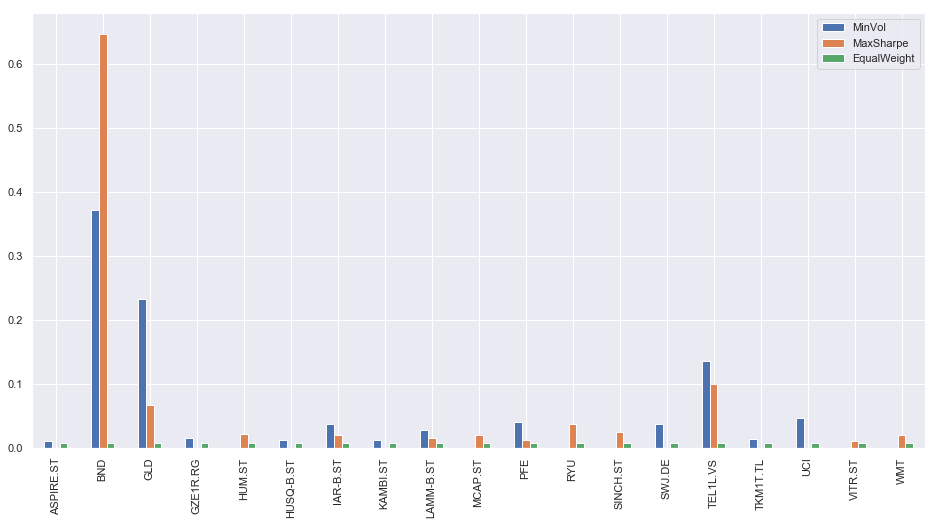

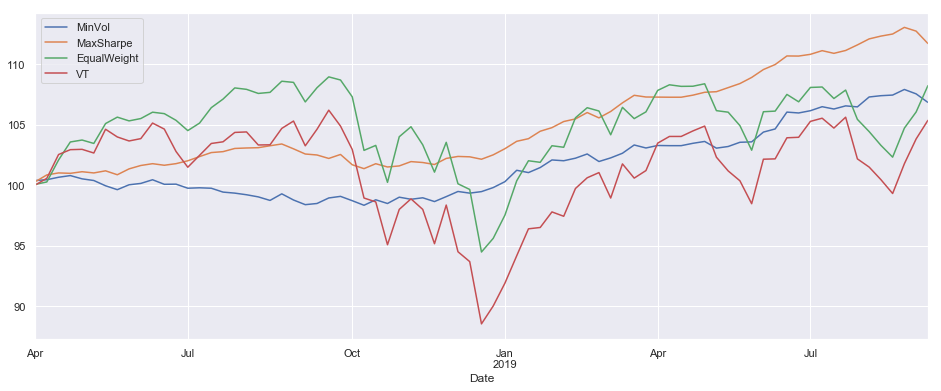

,MinVol,MaxSharpe,EqualWeight
BND,0.3726,0.6474,0.0082
GLD,0.2334,0.0670,0.0082
TEL1L.VS,0.1354,0.1004,0.0082
UCI,0.0476,0.0000,0.0082
PFE,0.0401,0.0127,0.0082
IAR-B.ST,0.0377,0.0200,0.0082
SWJ.DE,0.0376,0.0000,0.0082
LAMM-B.ST,0.0285,0.0164,0.0082
GZE1R.RG,0.0163,0.0000,0.0082
TKM1T.TL,0.0137,0.0000,0.0082


In [137]:
portfolios = pd.DataFrame(index = wret.index)

port_weights.sort_values(by=['MaxSharpe'], ascending=False).head(20)

for st in port_weights.columns:    
    strat = port_weights[port_weights[st] >= 0.01][st]
    
    if len(strat.index) > 3:
        port_weights[st] = 0.0
        for a in strat.index:
            port_weights.loc[a, st] = strat[a]
    
    port_weights[st] = port_weights[st].div(port_weights[st].sum())

port_weights[np.logical_or(port_weights['MinVol'] > 0.0, port_weights['MaxSharpe'] > 0.0)].plot.bar(figsize=(16,8))
plt.show()

portfolios['MinVol'] = np.dot(wret, port_weights['MinVol'])
portfolios['MaxSharpe'] = np.dot(wret, port_weights['MaxSharpe'])
portfolios['EqualWeight'] = np.dot(wret, np.ones(len(wret.columns))/len(wret.columns))
portfolios[benchmark] = wret[benchmark]

portfolios.add(1).cumprod().mul(100).plot(figsize=(16,6))
plt.show()

port_weights[np.logical_or(port_weights['MinVol'] > 0.0, 
                           port_weights['MaxSharpe'] > 0.0)].sort_values(ascending=False, by=['MinVol'])

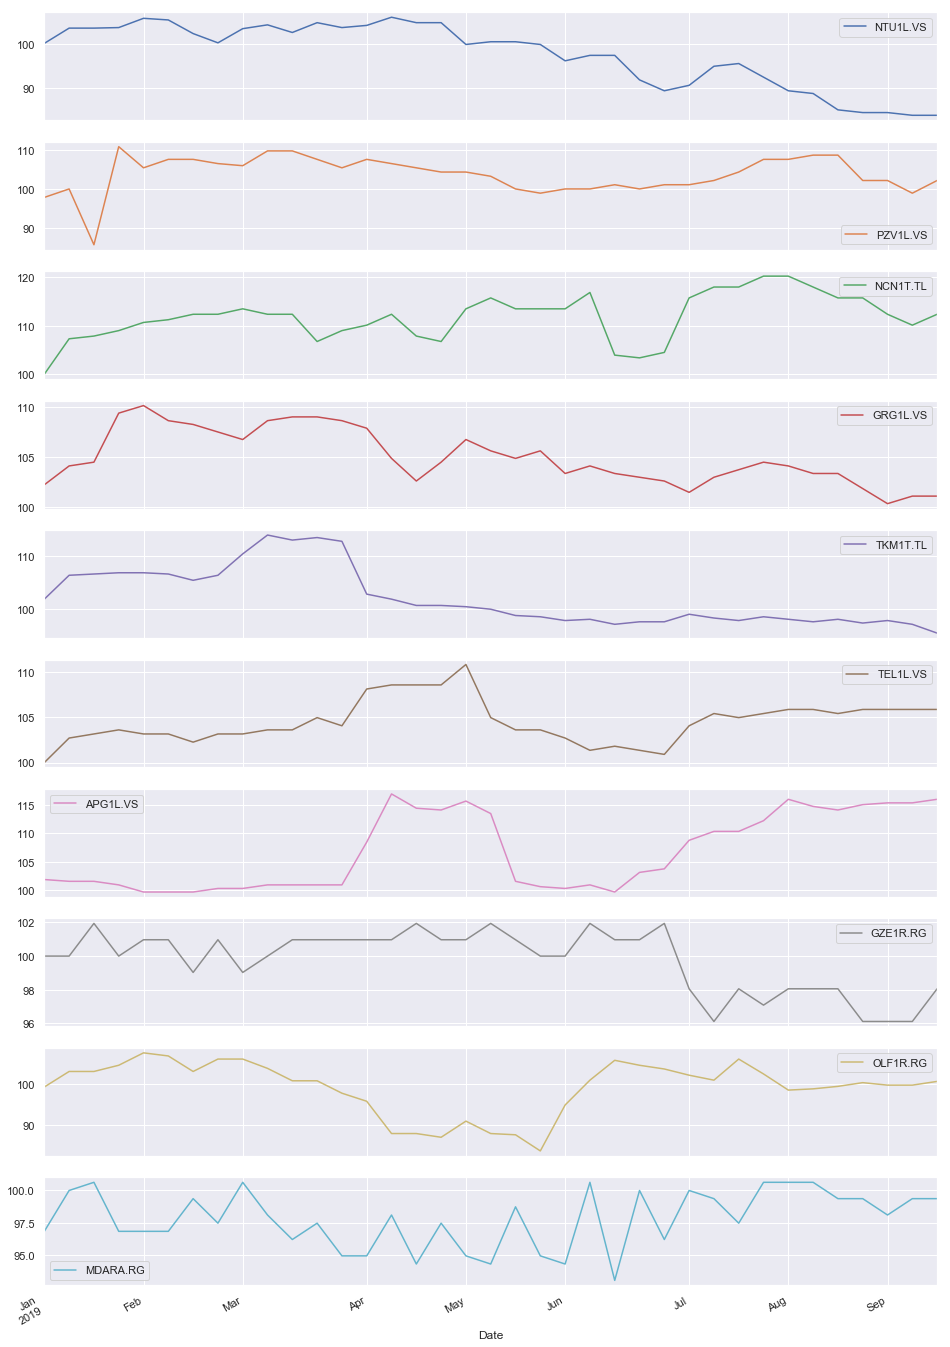

In [139]:
wret[baltic_stocks]['2019'].add(1).cumprod().mul(100).plot(figsize=(16,26), subplots=True)
plt.show()